# **Action Classification Using ucf101 Dataset**

# Load video data

https://www.tensorflow.org/datasets/catalog/ucf101

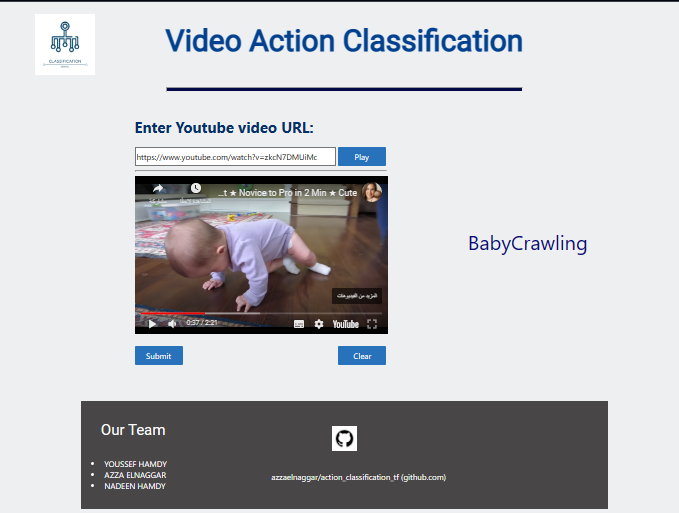

## Setup


In [ ]:
# The way this tutorial uses the `TimeDistributed` layer requires TF>=2.10
# !pip install -U "tensorflow>=V2.10"
!pip install remotezip tqdm opencv-python
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
import tqdm
import random
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
import remotezip as rz
import tensorflow as tf
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt


## Download a subset of the UCF101 dataset

The [UCF101 dataset](https://www.tensorflow.org/datasets/catalog/ucf101) contains 101 categories of different actions in video, primarily used in action recognition. You will use a subset of these categories in this project.

In [ ]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'

The above URL contains a zip file with the UCF 101 dataset. Create a function that uses the `remotezip` library to examine the contents of the zip file in that URL:

In [ ]:
def list_files_from_zip_url(zip_url):
  """ List the files in each class of the dataset given a URL with the zip file.

    Args:
      zip_url: A URL from which the files can be extracted from.

    Returns:
      List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(zip_url) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

Begin with a few videos and a limited number of classes for training. After running the above code block, notice that the class name is included in the filename of each video.

Define the `get_class` function that retrieves the class name from a filename. Then, create a function called `get_files_per_class` which converts the list of all files (`files` above) into a dictionary listing the files for each class:

In [ ]:
def get_class(fname):
  """ Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Returns:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

In [ ]:
def get_files_per_class(files):
  """ Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Returns:
      Dictionary of class names (key) and files (values). 
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

In [ ]:
NUM_CLASSES = 20
FILES_PER_CLASS = 50

In [ ]:
files = list_files_from_zip_url(URL)
files = [f for f in files if f.endswith('.avi')]

In [ ]:
files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())

In [ ]:
classes

Create a new function called `select_subset_of_classes` that selects a subset of the classes present within the dataset and a particular number of files per class:

In [ ]:
def select_subset_of_classes(files_for_class, classes, files_per_class):
  """ Create a dictionary with the class name and a subset of the files in that class.

    Args:
      files_for_class: Dictionary of class names (key) and files (values).
      classes: List of classes.
      files_per_class: Number of files per class of interest.

    Returns:
      Dictionary with class as key and list of specified number of video files in that class.
  """
  files_subset = dict()

  for class_name in classes:
    class_files = files_for_class[class_name]
    files_subset[class_name] = class_files[:files_per_class]

  return files_subset

In [ ]:
files_subset = select_subset_of_classes(files_for_class, classes[:NUM_CLASSES], FILES_PER_CLASS)
selected_classes=list(files_subset.keys())

In [ ]:

selected_classes

Define helper functions that split the videos into training, validation, and test sets. The videos are downloaded from a URL with the zip file, and placed into their respective subdirectiories.

In [ ]:
def download_from_zip(zip_url, to_dir, file_names):
  """ Download the contents of the zip file from the zip URL.

    Args:
      zip_url: A URL with a zip file containing data.
      to_dir: A directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file)

In [ ]:
def split_class_lists(files_for_class, count):
  """ Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.
    
    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Returns:
      Files belonging to the subset of data and dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

The following `download_ufc_101_subset` function allows you to download a subset of the UCF101 dataset and split it into the training, validation, and test sets. You can specify the number of classes that you would like to use. The `splits` argument allows you to pass in a dictionary in which the key values are the name of subset (example: "train") and the number of videos you would like to have per class.

In [ ]:
def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """ Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: A URL with a ZIP file with the data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      Mapping of the directories containing the subsections of data.
  """
  files = list_files_from_zip_url(zip_url)
  for f in files:
    path = os.path.normpath(f)
    tokens = path.split(os.sep)
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename
  
  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    random.shuffle(files_for_class[cls])
    
  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in classes}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

In [ ]:
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL,
                                       num_classes = NUM_CLASSES,
                                       splits = {"train": 30, "val": 10, "test": 10},
                                       download_dir = download_dir)

After downloading the data, you should now have a copy of a subset of the UCF101 dataset. Run the following code to print the total number of videos you have amongst all your subsets of data.

In [ ]:
video_count_train = len(list(download_dir.glob('train/*/*.avi')))
video_count_val = len(list(download_dir.glob('val/*/*.avi')))
video_count_test = len(list(download_dir.glob('test/*/*.avi')))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

# plot no. of training videos 

In [ ]:
classes_name=[]
classes_count=[]
data={}
for f in os.listdir(download_dir):
  data[f]=download_dir / f
for vid in os.listdir(data['train']):
  classes_name.append(vid)
  classes_count.append(len(vid))

In [ ]:

# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))

# Horizontal Bar Plot
ax.barh(classes_name,classes_count)

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
	ax.spines[s].set_visible(False)

# Add x, y gridlines
ax.grid(b = True, color ='grey',
		linestyle ='-.', linewidth = 0.5,
		alpha = 0.2)

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
	plt.text(i.get_width()+0.2, i.get_y()+0.5,
			str(round((i.get_width()), 2)),
			fontsize = 10, fontweight ='bold',
			color ='grey')

# Add Plot Title
ax.set_title('videos in each class' ,
			loc ='center', )

# Show Plot
plt.show()


## Create frames from each video file

The `frames_from_video_file` function splits the videos into frames, reads a randomly chosen span of `n_frames` out of a video file, and returns them as a NumPy `array`.
To reduce memory and computation overhead, choose a **small** number of frames. In addition, pick the **same** number of frames from each video, which makes it easier to work on batches of data.


In [ ]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [ ]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

## Visualize video data


In [ ]:
video_path = "/content/UCF101_subset/train/BabyCrawling/v_BabyCrawling_g04_c01.avi"

In [ ]:
sample_video = frames_from_video_file(video_path, n_frames = 10)
sample_video.shape

In [ ]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./sample.gif', converted_images, fps=10)
  return embed.embed_file('./sample.gif')

In [ ]:
to_gif(sample_video)

Next, define the `FrameGenerator` class in order to create an iterable object that can feed data into the TensorFlow data pipeline. The generator (`__call__`) function yields the frame array produced by `frames_from_video_file` and a one-hot encoded vector of the label associated with the set of frames.

In [ ]:
class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

Test out the `FrameGenerator` object before wrapping it as a TensorFlow Dataset object. Moreover, for the training dataset, ensure you enable training mode so that the data will be shuffled.

In [ ]:
fg = FrameGenerator(subset_paths['train'], 10, training=True)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Finally, create a TensorFlow data input pipeline. This pipeline that you create from the generator object allows you to feed in data to your deep learning model. In this video pipeline, each element is a single set of frames and its associated label. 

In [ ]:
# Create the training set
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], 10, training=True),
                                          output_signature = output_signature)

Check to see that the labels are shuffled. 

In [ ]:
for frames, labels in train_ds.take(10):
  print(labels)

In [ ]:
# Create the validation set
val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], 10),
                                        output_signature = output_signature)

In [ ]:
test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], 10),
                                        output_signature = output_signature)

## Configure the dataset for performance

Use buffered prefetching such that you can yield data from the disk without having I/O become blocking. 

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

the data should be shaped as a five dimensional object. These dimensions are as follows: `[batch_size, number_of_frames, height, width, channels]`. 


In [ ]:
train_ds = train_ds.batch(16)
val_ds = val_ds.batch(16)
test_ds = test_ds.batch(16)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

## MODEL

In [ ]:
net = tf.keras.applications.ResNet50(include_top = False)
net.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=255),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(20),
    tf.keras.layers.GlobalAveragePooling3D()
])

model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])


In [ ]:
results=model.fit(train_ds, 
          epochs = 20,
          validation_data = val_ds
          ,callbacks = tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss')
          )

## we choose model with 10 epochs

In [ ]:
model.summary()

In [ ]:
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/U101_model_30C.h5")

# Model class must be defined somewhere
# model= tf.keras.models.load_model("C:/Users/azzaa/Downloads/U101_model.h5")

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# Evaluation

In [ ]:
model.evaluate(test_ds, return_dict=True)

In [ ]:
def get_actual_predicted_labels(dataset):
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [ ]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [ ]:
fg = FrameGenerator(subset_paths['train'], 8, training = True)
label_names = list(fg.class_ids_for_name.keys())

In [ ]:
import seaborn as sns
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, label_names, 'test')